### Adaptive Hyperparameter Optimization with Dask-ML

This notebook demonstrates Hyperband, a model selection algorithm now part of Dask-ML. It showcases:

* **Problem:** Tuning hyperparameters for good model performance.
* **Realistic Use Case:** Image denoising with a deep learning model.
* **Hyperparameter Optimization:**
    * Explores parameter space with Hyperband.
    * Compares with early stopping techniques.
* **Results Visualization:**
    * Analyzes input/output data.
    * Visualizes best model's performance.

### Importance of Hyperparameter Tuning

Any machine learning model requires tuning hyperparameters for optimal performance. This notebook focuses on image denoising, where crucial parameters include:

```python
params = {
    'module__init': ['xavier_uniform_', 'xavier_normal_', 'kaiming_uniform_', 'kaiming_normal_'],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}


These parameters control:

* Model initialization
* Activation function
* Optimizer and its hyperparameters (learning rate, momentum, etc.)
* Batch size

In [1]:
import warnings
warnings.filterwarnings('ignore') # Reduce number of messages/warnings displayed

In [2]:
# !export PYTHONPATH=../src:$PYTHONPATH
# !echo $PYTHONPATH
!cp -u ../src/noisy_mnist.py . 


In [3]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2024-04-15


In [4]:
import os
path = "/".join(os.getcwd().split("/")[:-1])
results_folder = f"data/results/skorch_run/{today}"
absolutepath_to_results = os.path.join(path,results_folder)
os.makedirs(absolutepath_to_results,exist_ok=True)


In [5]:
import socket
s=socket.socket()
s.bind(("", 0))
port = s.getsockname()[1]
s.close()

In [6]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

In [7]:
cluster = LocalCUDACluster(dashboard_address=f"127.0.0.1:{port}")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:45215/status,
Dashboard: http://127.0.0.1:45215/status,Workers: 2
Total threads: 2,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41167,Workers: 2
Dashboard: http://127.0.0.1:45215/status,Total threads: 2
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:41283,Total threads: 1
Dashboard: http://127.0.0.1:41963/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:37193,


In [8]:
%time client.upload_file('../models/autoencoder.py')

CPU times: user 1.97 s, sys: 726 ms, total: 2.7 s
Wall time: 8.97 s


{'tcp://127.0.0.1:41283': {'status': 'OK'},
 'tcp://127.0.0.1:43071': {'status': 'OK'}}

In [9]:
import dask_ml
print (f'Dask ml version : {dask_ml.__version__}' ) 

Dask ml version : 2023.3.24


### Dataset and Model

* **Dataset:** Noisy MNIST images for denoising.
* **Model:** Deep learning autoencoder with a latent dimension of 49.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [11]:
import noisy_mnist
chunk_size = 70_000 // 3
_X, _y = noisy_mnist.dataset()
_X = _X[:chunk_size * 3]
_y = _y[:chunk_size * 3]

In [12]:
_X.shape, _X.dtype, _X.min(), _X.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [13]:
_y.shape, _y.dtype, _y.min(), _y.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [14]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 3, d))
y = da.from_array(_y, chunks=n // 3)
X, y

(dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>,
 dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>)

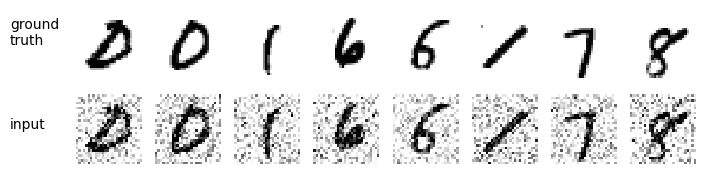

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

rng = check_random_state(42)
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = rng.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig(f"{absolutepath_to_results}/input-output.svg", bbox_inches="tight")
plt.show()

### Model Architecture

The autoencoder model uses PyTorch through the scikit-learn interface [skorch].

[skorch]:https://github.com/dnouri/skorch

In [16]:
from autoencoder import Autoencoder, NegLossScore
import torch


def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

class TrimParams(NegLossScore):
    def set_params(self, **kwargs):
        kwargs = trim_params(**kwargs)
        return super().set_params(**kwargs)

model = TrimParams(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

### Hyperparameter Optimization Setup

* Uses Dask for distributed computing.
* Defines parameter search space (`params`).
* Sets random state for reproducibility.

##### Parameters

The parameters interesting in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD

In [17]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

Testing `optimizer` to be `SGD` or `Adam` comes from here "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [18]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X, _y = make_classification(n_samples=n, n_features=d,
#                              random_state=1)
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

In [19]:
import json

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


In [20]:

import msgpack

def save_search(search, today, prefix, X, y):
    # create the folder into results and direct the results over there
    path = "/".join(os.getcwd().split("/")[:-1])
    results_folder = f"results/skorch_run/{today}"
    absolutepath_to_results = os.path.join(path,results_folder)
    os.makedirs(absolutepath_to_results,exist_ok=True)
    pre = f"{absolutepath_to_results}/{today}-{prefix}-"


    with open(pre + "test.npz", "wb") as f:
        y_hat = search.predict(X)
        y_hat = y_hat.compute()
        np.savez(f, X=X, y=y, y_hat=y_hat)
    # skorch models aren't pickable
    with open(pre + "params.json", "w") as f:
        params = {k: fmt(v) for k, v in search.get_params().items() if "estimator" not in k and "param_distribution" not in k}
        json.dump(params, f)
    # with open(pre + "best-model.joblib", "wb") as f:
    #     joblib.dump(search.best_estimator_, f)
    with open(pre + "best-params-and-score.json", "w") as f:
        json.dump({"params": search.best_params_, "score": search.best_score_}, f)

    with open(pre + "history.json", 'w') as f:
        json.dump(search.history_, f)

    with open(pre + "cv_results.json", 'w') as f:
        json.dump(fmt(search.cv_results_), f)

### Hyperparameter Optimization Algorithms

Compares different optimization algorithms:

* **Hyperband:** Efficiently explores and exploits the parameter space.
* **Hyperband with Successive Overfitting Prevention (SOP):** Early stops models that don't improve, potentially reducing wasted evaluations.
* **Incremental Search with Patience:** Adaptively adds and removes models based on performance.

#### Data Exploration

Visualizes noisy and clean images to understand the task.

In [21]:
X

dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>

In [22]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test

(dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(7002, 784), dtype=float32, chunksize=(2334, 784), chunktype=numpy.ndarray>)

In [23]:
y_train

dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>

In [24]:
from sklearn.linear_model import SGDClassifier

max_iter = 20 # originally this number was 250 to make a decent denoising 
history = {}
cv_results = {}
searches = {}

In [25]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
   

### Hyperparameter Tuning with Hyperband

Trains the model with Hyperband and analyzes the results:

* Best model parameters
* Best model score
* Visualizations of the best model's output

In [26]:
search = HyperbandSearchCV(model, params, max_iter, random_state=42)

In [27]:
y_train.shape

(62997, 784)

In [28]:
%%time
search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 3.1491589546203613
steps = 1, loss = 1.0405787229537964
steps = 1, loss = 49.95913314819336
steps = 1, loss = 1.7627955675125122
steps = 1, loss = 1.7986866235733032
steps = 1, loss = 0.7119414806365967
steps = 1, loss = 2.1237661838531494
steps = 1, loss = 1.9973433017730713
steps = 6, loss = 3.1288132667541504
steps = 20, loss = 2.5897934436798096
steps = 20, loss = 1.9852360486984253
steps = 6, loss = 49.84486770629883
steps = 6, loss = 3.0879392623901367
steps = 6, loss = 2.5509018898010254
steps = 20, loss = 2.4282631874084473
steps = 6, loss = 2.658573627471924
steps = 1, loss = 1.950537085533142
steps = 1, loss = 2.709622859954834
steps = 1, loss = 0.6947774291038513
steps = 1, loss = 2.06404447555542
steps = 1, loss = 1.9618244171142578
steps = 1, loss = 2.44063663482666
steps = 1, loss = 49.63414764404297
steps = 1, loss = 2.066892147064209
steps = 1, loss = 2.119412422180176
steps = 2, loss = 0.6953856945037842
steps = 2, loss = 2.701002597808838
steps = 2, 

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=20,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'SG...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  random_state=42)

In [29]:
# timing_stats = client.profile(filename="hyperband.html")
# with open(f"{absolutepath_to_results}/hyperband-timing.json", "w") as f:
#     json.dump(timing_stats[0], f)

In [30]:
search.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): PReLU(num_parameters=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [31]:
search.best_score_

-1.8354138135910034

In [32]:
search.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.06006006006006006,
 'optimizer__lr': 0.03487727474814178,
 'optimizer': 'SGD',
 'module__init': 'xavier_uniform_',
 'module__activation': 'PReLU',
 'batch_size': 256}

In [33]:
save_search(search, today, "hyperband", X_test.compute(), y_test.compute())

### Hyperband with SOP

Trains the model with Hyperband with SOP and analyzes the results.


In [34]:
search_patience = HyperbandSearchCV(model, params, max_iter, random_state=42, patience=True)

In [35]:
%%time
search_patience.fit(X_train, y_train, **fit_params)

steps = 1, loss = 0.7180733680725098
steps = 1, loss = 2.2156736850738525
steps = 1, loss = 1.158869743347168
steps = 1, loss = 1.916359305381775
steps = 1, loss = 3.23938250541687
steps = 1, loss = 49.953426361083984
steps = 1, loss = 1.7829312086105347
steps = 1, loss = 1.9808491468429565
steps = 7, loss = 1.7041715383529663
steps = 7, loss = 2.7959864139556885
steps = 6, loss = 3.117126226425171
steps = 6, loss = 2.641444444656372
steps = 7, loss = 2.0049614906311035
steps = 6, loss = 3.122912883758545
steps = 6, loss = 2.1882503032684326
steps = 6, loss = 2.600801467895508
steps = 1, loss = 2.4645891189575195
steps = 1, loss = 1.9655671119689941
steps = 1, loss = 2.0668179988861084
steps = 1, loss = 2.112539768218994
steps = 1, loss = 2.062242269515991
steps = 1, loss = 1.9628089666366577
steps = 1, loss = 49.99369430541992
steps = 1, loss = 2.68534779548645
steps = 1, loss = 0.6956506371498108
steps = 2, loss = 2.372814416885376
steps = 2, loss = 0.6972817182540894
steps = 2, loss

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=20,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'SG...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  patience=True, random_state=42)

In [36]:
save_search(search_patience, today, "hyperband-w-patience", X_test.compute(), y_test.compute())

In [37]:
# timing_stats = timing_stats = client.profile(filename="hyperband.html")
# with open(f"{absolutepath_to_results}/hyperband+sop-timing.json", "w") as f:
#     json.dump(timing_stats[0], f)

In [38]:
search_patience.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): PReLU(num_parameters=1)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [39]:
search_patience.best_score_

-1.0224334001541138

In [40]:
search_patience.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.06006006006006006,
 'optimizer__lr': 0.03487727474814178,
 'optimizer': 'SGD',
 'module__init': 'xavier_uniform_',
 'module__activation': 'PReLU',
 'batch_size': 256}

### Visualizing output of best estimator

In [41]:
noisy_test = X_test.compute()

In [42]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(7002, 2, 784)

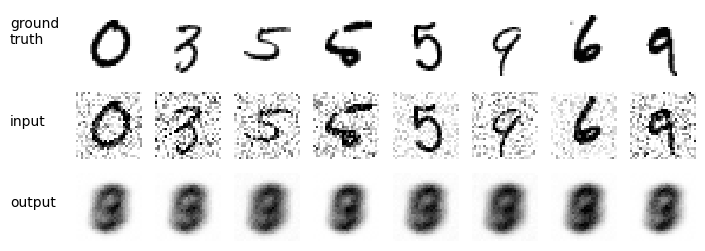

In [43]:
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.savefig(f"{absolutepath_to_results}/best-out.svg", bbox_inches="tight")
plt.show()

### Setting Parameters for Hyperband

Tuning Hyperband requires setting:

* `max_iter`: Number of epochs or data passes for training.
* Chunk size for the data array.

These determine the number of models evaluated and the overall search complexity.

### Comparison with Early Stopping Techniques

Compares Hyperband with:

* **Passive Search:** No early stopping, evaluates all models.
* **Incremental Search with Patience:** Early stops models that don't improve on a validation set.

Analyzes:

* Best model scores
* Visualizations of the best model's output

In [44]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

# n_workers = 32 or len(client.cluster.workers)
n_workers = len(client.cluster.workers)
num_models = max(n_workers, total_calls // num_calls)
num_calls, num_models, total_calls

(20, 7, 144)

In [45]:
from dask_ml.model_selection import IncrementalSearchCV

passive_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=False,
    n_initial_parameters=num_models,
    max_iter=num_calls,
    random_state=42
)

In [46]:
%%time
passive_search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 2.009619951248169
steps = 1, loss = 0.7750937342643738
steps = 1, loss = 1.0185312032699585
steps = 1, loss = 1.966507911682129
steps = 1, loss = 2.059221029281616
steps = 1, loss = 0.7133487462997437
steps = 1, loss = 1.969589352607727
steps = 2, loss = 2.1883339881896973
steps = 2, loss = 1.6228523254394531
steps = 2, loss = 2.417375326156616
steps = 2, loss = 0.7701475620269775
steps = 2, loss = 1.261467456817627
steps = 2, loss = 2.4164106845855713
steps = 2, loss = 2.2483668327331543
steps = 3, loss = 1.581132411956787
steps = 3, loss = 2.457209587097168
steps = 3, loss = 1.7830049991607666
steps = 3, loss = 1.0214272737503052
steps = 3, loss = 2.4578216075897217
steps = 3, loss = 2.622565746307373
steps = 3, loss = 2.4951446056365967
steps = 4, loss = 2.72416090965271
steps = 4, loss = 1.7233872413635254
steps = 4, loss = 2.8120691776275635
steps = 4, loss = 1.3382542133331299
steps = 4, loss = 1.8747538328170776
steps = 4, loss = 2.7137820720672607
steps = 4, l

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=20, n_initial_parameters=7,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_normal...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    random_state=42)

In [47]:
save_search(passive_search, today, "passive", X_test.compute(), y_test.compute())

In [48]:
# timing_stats = client.profile()
# with open(f"{absolutepath_to_results}/final-final-timings.json", "w") as f:
#     json.dump(timing_stats, f)

* patience: `max_iter // 8` (10 epochs)
* n_initial: `2 * num_models`

This requires choosing

* the explore/exploit tradeoff (`patience` vs `n_initial`)
* some estimate on many models will take advantage of `patience` to get total number of partial fit calls

In [49]:
from dask_ml.model_selection import IncrementalSearchCV

patience_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 10,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=42,
)

In [50]:
%%time
patience_search.fit(X_train, y_train, **fit_params)

steps = 1, loss = 2.1181106567382812
steps = 1, loss = 1.960186243057251
steps = 1, loss = 2.478877305984497
steps = 1, loss = 2.3099262714385986
steps = 1, loss = 0.7696030735969543
steps = 1, loss = 2.404611587524414
steps = 1, loss = 2.0132172107696533
steps = 1, loss = 1.9090073108673096
steps = 1, loss = 2.0980758666992188
steps = 1, loss = 0.7151800394058228
steps = 1, loss = 0.7235367298126221
steps = 1, loss = 1.9738233089447021
steps = 1, loss = 1.0870850086212158
steps = 1, loss = 49.99527359008789
steps = 2, loss = 2.218050718307495
steps = 2, loss = 2.5066118240356445
steps = 2, loss = 2.772975444793701
steps = 2, loss = 2.4966256618499756
steps = 2, loss = 1.2413793802261353
steps = 2, loss = 2.675715208053589
steps = 2, loss = 2.07818341255188
steps = 2, loss = 2.4301962852478027
steps = 2, loss = 0.784129798412323
steps = 2, loss = 2.0688977241516113
steps = 2, loss = 2.2166242599487305
steps = 2, loss = 1.5032137632369995
steps = 2, loss = 1.6460254192352295
steps = 2, 

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=20, n_initial_parameters=14,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norma...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    patience=2, random_state=42)

In [51]:
patience_search.best_score_

-0.784129798412323

In [52]:
save_search(patience_search, today, "patience", X_test.compute(), y_test.compute())

In [53]:
timing_stats = client.profile()
with open(f"{absolutepath_to_results}/final-timings.json", "w") as f:
    json.dump(timing_stats, f)

In [54]:
data, fig = client.get_task_stream(plot="save", filename=f"{absolutepath_to_results}/task_stream.html")

In [55]:
import pandas as pd
df = pd.DataFrame(list(data))

In [56]:
df.head()

""


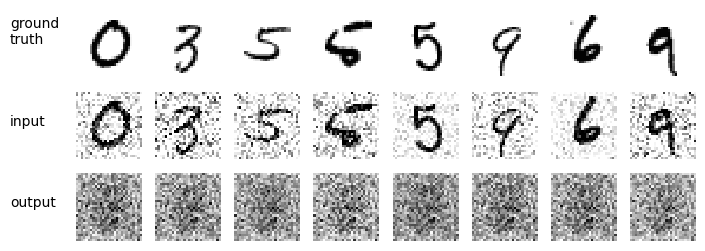

In [57]:
clean_hat = patience_search.best_estimator_.predict(noisy_test)

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.savefig(f"{absolutepath_to_results}/patience-best-out.svg", bbox_inches="tight")
plt.show()

### Conclusion

This notebook demonstrates hyperparameter optimization for image denoising using Dask-ML. It compares different algorithms and highlights the importance of choosing appropriate parameters for each approach.

This enhanced script provides clear explanations, code comments, and visualizations to effectively teach hyperparameter optimization concepts and best practices.